![LogoTec](img/logoTec.png)

## TC 5033
### Word Embeddings
### Team Members:
- A01200230 - Armando Bringas Corpus

<br>

### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested. 

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%): 
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

# Used libraries to plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Check torch version
torch.__version__

'2.1.0'

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [5]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [6]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [7]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))

['welcome', 'to', 'te3007'] [3314, 4, 0]


In [8]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [9]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [10]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [11]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))
    
    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [12]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [14]:
EMBEDDING_SIZE = 50 # Transform to a 50-dimensional vector to capture, decided to make same as max_tokens
NEURONS = 32
LAYERS = 2
NUM_CLASSES = len(labels) # Should be 4

#### RNN Model class

In [15]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        # Chosen LSTM that is ideal for sequential data as text data
        self.rnn = nn.LSTM(embed_size, hidden, layers, batch_first = True) 
        self.fc = nn.Linear(hidden, NUM_CLASSES) 
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Apply the embedding layer that turns word indexes into embeddings
        x = self.embedding_layer(x.long())
        
        # Forward propagate the LSTM
        out, (hn, cn) = self.rnn(x)
        
        # Take the output of the last sequence step for each sample
        out = out[:, -1, :]
        
        # Apply the fully connected layer and return the output
        out = self.fc(out)
        
        return out

#### Accuracy Function

In [16]:
def accuracy(model, loader):
    num_correct = 0 # correct predictions
    num_total = 0 # total number of examples

    # No need to track gradients for validation, hence no_grad context
    with torch.no_grad():
        for x_i, y_i in loader:
            # Move tensors to the correct device
            x_i, y_i = x_i.to(device, dtype=torch.float32), y_i.to(device, dtype=torch.long)
            scores = model(x_i)
            _, predictions = scores.max(dim=1)
            num_correct += (predictions == y_i).sum().item()
            num_total += y_i.size(0)

    # Compute the accuracy
    accuracy = num_correct / num_total
    
    return accuracy

#### Train Function

In [17]:
def train(model, optimiser, epochs=100):
    # Assign model to current processing device
    model = model.to(device=device)

    # Epoch loop
    for epoch in range(epochs):

        # Loop for training the model on each of the minibatches created
        for i, (x_i, y_i) in enumerate(train_loader):

            # Put model on training mode (enable gradients and dropouts)
            model.train()

            # Assign current batch of data to the assigned processing unit with correct data type
            x_i = x_i.to(device=device, dtype=torch.float32)
            y_i = y_i.to(device=device, dtype=torch.long)

            # Calculate prediction scores
            scores = model(x_i)

            # Calculate the cost
            cost = F.cross_entropy(input= scores, target=y_i)

            # Reset gradients
            optimiser.zero_grad()

            # Calculate gradients
            cost.backward()

            # Update training parameters
            optimiser.step()

        # Calculate accuracy on the validation partition
        acc_train = accuracy(model, val_loader)
        acc_val = accuracy(model, train_loader)

        # Return results
        print(f'Epoch: {epoch}, cost: {cost.item()}, accuracy_train: {acc_train}, accuracy_val: {acc_val}')

### Training RNN

In [18]:
epochs = 20 
lr = 0.005 
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [19]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch: 0, cost: 0.2985561490058899, accuracy_train: 0.8708333333333333, accuracy_val: 0.8948055555555555
Epoch: 1, cost: 0.2750178575515747, accuracy_train: 0.9035833333333333, accuracy_val: 0.9404074074074074
Epoch: 2, cost: 0.20195627212524414, accuracy_train: 0.909, accuracy_val: 0.9587962962962963
Epoch: 3, cost: 0.0976366475224495, accuracy_train: 0.9065833333333333, accuracy_val: 0.9707407407407408
Epoch: 4, cost: 0.11110001057386398, accuracy_train: 0.90375, accuracy_val: 0.9798425925925925
Epoch: 5, cost: 0.08897141367197037, accuracy_train: 0.9016666666666666, accuracy_val: 0.9866111111111111
Epoch: 6, cost: 0.07694470882415771, accuracy_train: 0.8949166666666667, accuracy_val: 0.9863240740740741
Epoch: 7, cost: 0.031342193484306335, accuracy_train: 0.9014166666666666, accuracy_val: 0.9920277777777777
Epoch: 8, cost: 0.028996065258979797, accuracy_train: 0.9010833333333333, accuracy_val: 0.9930092592592593
Epoch: 9, cost: 0.027846548706293106, accuracy_train: 0.898166666666666

In [20]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.9009


### Test Model and Evaluation

#### Sampling Function

In [21]:
def sample_text(model, loader):
    # Randomly sample an index from the dataset
    idx = np.random.randint(len(loader.dataset))
    y_label, text = loader.dataset[idx]

    # Print the text of the document
    print('Text from document:\n\n{}'.format(text))
    
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Tokenize and preprocess the input text
    processed_text = tokeniser(text) 
    processed_text_ids = vocab(processed_text)
    text_tensor = torch.tensor([processed_text_ids], dtype=torch.long).to(device)

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Forward pass, get model predictions
        outputs = model(text_tensor)

    # Assuming the output is logits, get the highest scoring class
    _, predicted_idx = torch.max(outputs, 1)

    # Map the predicted index to the corresponding label
    predicted_label = labels[predicted_idx.item()]

    # Print the real and predicted labels
    print('\nReal Label: {}'.format(labels[y_label-1]))
    print('\nPredicted Label: {}'.format(predicted_label))

    # return predicted_label, y_label

In [22]:
sample_text(rnn_model, test_loader)

Text from document:

Hard Drive: SP Your XP, RSN Don #39;t have Windows XP? Listen up anyway, because there #39;s a lesson to learn, not to mention sly put downs you can use to annoy your Windows-XP-using-friends so they #39;ll finally break down and admit 

Real Label: Sci/Tech

Predicted Label: Sci/Tech


#### Confusion Matrix

In [23]:
def calculate_confusion_matrix(model, loader, device):
    # Set the model to evaluation mode to deactivate dropout layers, etc.
    model.eval()

    # Transfer the model to the specified device (CPU or GPU)
    model.to(device)

    # Initialize lists to hold predicted and true labels
    all_preds = []
    all_labels = []

    # Disable gradient calculations as they aren't needed for evaluation
    with torch.no_grad():
        
        # Iterate over the data loader
        for inputs, labels in loader:
            
            # Transfer inputs and labels to the specified device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get model predictions for the current batch
            outputs = model(inputs)
            
            # Find the index of the maximum logit score to get the predicted label
            _, preds = torch.max(outputs, 1)
            
            # Append the predictions and labels to the lists, converting them to CPU and numpy for later processing
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate the lists of preds and labels to form a single array for each
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute the confusion matrix using true labels and predictions
    cm = confusion_matrix(all_labels, all_preds)

    # Return the confusion matrix
    return cm

In [24]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', xticklabels=class_names, yticklabels=class_names, cbar=False) 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

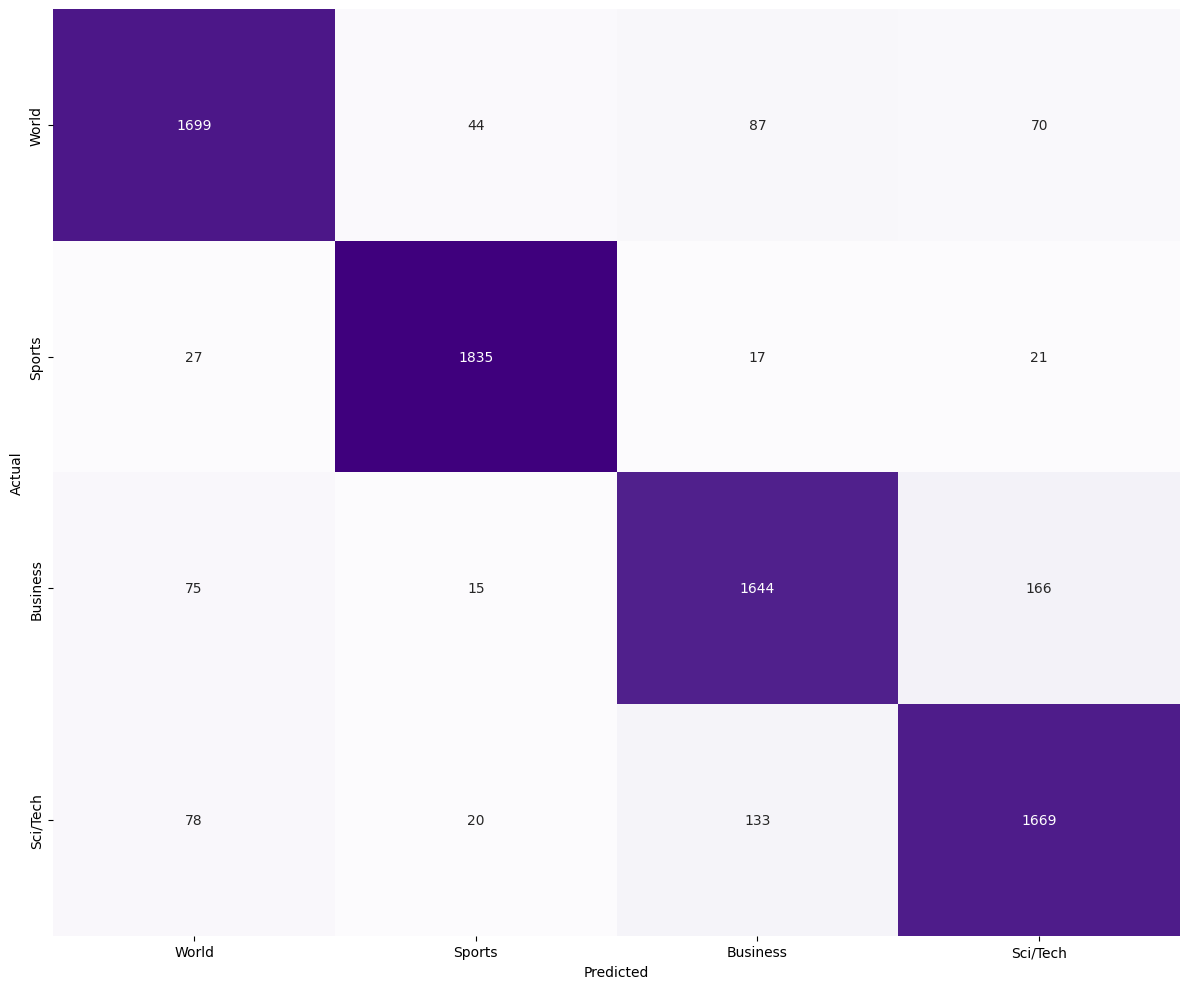

In [25]:
cm = calculate_confusion_matrix(rnn_model, test_loader, device)
plot_confusion_matrix(cm, labels)